
# Faces recognition using NMF and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  LFW: http://vis-www.cs.umass.edu/lfw/


In [1]:
%matplotlib inline
from time import time
import logging
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import manifold
from sklearn.decomposition import NMF

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

2017-03-17 22:37:17,845 Loading LFW people faces from /home/chandu/scikit_learn_data/lfw_home


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
n_comp_1 = np.arange(150,250,3)
accuracies = []
components = []
for i in xrange(len(n_comp_1)):
    n_components = n_comp_1[i]
    
    model = NMF(n_components=n_components, init='random', random_state=0)
    nmf = model.fit(X_train)
    
    X_train_nmf = nmf.transform(X_train)
    X_test_nmf = nmf.transform(X_test)

    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_nmf, y_train)
    y_pred = clf.predict(X_test_nmf)

    accuracies.append(float(np.sum(y_test==y_pred))/len(y_pred))
    components.append(n_components)

    print('For '+str(n_components)+' components, accuracy is '+str(float(np.sum(y_test==y_pred))/len(y_pred))+' confusion matrix is: ')
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
    print(classification_report(y_test, y_pred, target_names=target_names))

For 150 components, accuracy is 0.819875776398 confusion matrix is: 
[[  6   4   0   0   1   0   2]
 [  1  54   1   3   0   1   0]
 [  0   3  19   4   0   0   1]
 [  2   3   5 130   1   2   3]
 [  0   0   2   4  17   1   1]
 [  0   0   0   4   2   8   1]
 [  0   2   2   2   0   0  30]]
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.46      0.55        13
     Colin Powell       0.82      0.90      0.86        60
  Donald Rumsfeld       0.66      0.70      0.68        27
    George W Bush       0.88      0.89      0.89       146
Gerhard Schroeder       0.81      0.68      0.74        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.79      0.83      0.81        36

      avg / total       0.82      0.82      0.82       322

For 153 components, accuracy is 0.791925465839 confusion matrix is: 
[[  5   6   0   2   0   0   0]
 [  1  48   2   5   0   2   2]
 [  1   1  20   4   0   0   1]
 [  2   3   6 126

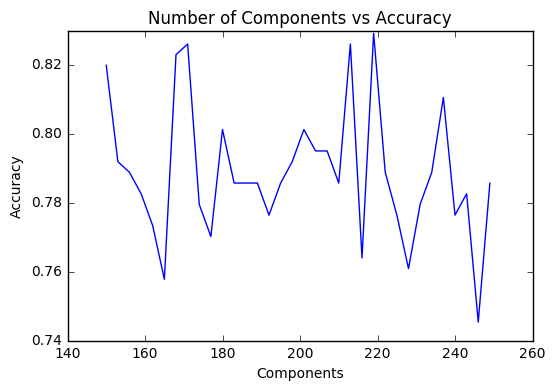

In [4]:
plt.plot(components,accuracies)
plt.title('Number of Components vs Accuracy')
plt.xlabel('Components')
plt.ylabel('Accuracy')
plt.show()